# Euler Riemann Problem

To compute the fluxes through the interface, we will need to solve the Riemann
problem for the Euler equations.  We will formulate it such that we have
left and right primitive variable states and we want to find the unique state on the interface:

$${\bf q}_{i+1/2} = \mathcal{R}({\bf q}_{i+1/2,L}, {\bf q}_{i+1/2,R})$$

Information about the jump across this interface will be carried away from the interface by the 3 hydrodynamic waves ($u$ and $u\pm c$).  We can define 4 regions separated by the three waves, which we'll call $L$, $L_\star$, $R_\star$, and $R$.

![Riemann solution structure](riemann-waves.png)

We see that:

* $L$ and $R$ are just our original states&mdash;since no waves have reached them yet, the state is unchanged.

* The star states are between the left and right state.

  * We know from the eigenvectors that all 3 primitive variables, $(\rho, u, p)$ jump across the left and right state. 
  
  * From the center eigenvector, we know only the density jumps.  That means in the star region, the only unknowns are:

    $$u_\star, p_\star, \rho_{\star,L}, \rho_{\star,R}$$

## Finding the star state

Our first goal is to find the star state.  To do this,
we need to know how much each variable changes across each of the three waves.  To complicate matters, the left and right waves can be either shocks or rarefactions.  

```{note}
We will assume a gamma-law gas for the rest of this notebook.  Keep
in mind that many astrophysical environments need a more general gas, and
while the expressions are different, the basic ideas will carry over to
the general gas case.

An discussion of how the Riemann problem differs for a general EOS can be
found in [Efficient Solution Algorithms for the Riemann
Problem for Real Gases](https://crd.lbl.gov/assets/pubs_presos/AMCS/ANAG/A17.pdf) by Colella & Glaz.

An implementation of an exact Riemann solver for a general EOS can be found in [Castro](https://github.com/AMReX-Astro/Castro/tree/main/Util/exact_riemann) and is discussed
in [On the Piecewise Parabolic Method for Compressible Flow With Stellar Equations of State](https://ui.adsabs.harvard.edu/abs/2015ApJS..216...31Z/abstract) by Zingale & Katz.
```

For a gamma-law gas, we can write down analytic expressions for the change in the primitive variables across both a rarefaction and shock.  We can then solve these to find the state in-between the left and right waves&mdash;the star state.

### Shock jump conditions

For the case where the left or right wave is a shock, we use the Rankine-Hugoniot jump conditions to connect the states across the wave.  The generalized version of the jump conditions for a system is:

$$\frac{\bf{F}({\bf U}_\star) - {\bf F}({\bf U_s})}{{\bf U}_\star - {\bf U}_s} = S$$

where $s \in [L, R]$ is the state to the left or right of the interface and $S$ is the shock speed.


We can write the jump conditions in the frame of the shock as (for the left wave).  Then:

\begin{align*}
\rho_L \hat{u}_L &= \rho_\star \hat{u}_\star \\
\rho_L \hat{u}_L^2 + p_L &= \rho_\star {\hat{u}_\star}^2 + p_\star \\
\rho_L e_L \hat{u}_L + p_L \hat{u}_L + \frac{1}{2} \rho_L \hat{u}_L^3 &=
       \rho_\star e_\star \hat{u}_\star + p_\star \hat{u}_\star + \frac{1}{2}\rho_\star {\hat{u}_\star}^3
\end{align*}

where $\hat{u} = u - S$ (for both the $\star$ and $L$ velocity), and $S$ is the shock speed.

With a lot of algebra, you can find the relation of $u_\star$ to $u_L$ as:

$$u_\star = u_L + \frac{2 c_L}{\sqrt{2 \gamma(\gamma-1)}} \frac{1 - \frac{p_\star}{p_L}}{\sqrt{1 + \frac{\gamma + 1}{\gamma -1} \frac{p_\star}{p_L}}}$$

and similarly for a shock across the right wave:

$$u_\star = u_R - \frac{2 c_R}{\sqrt{2 \gamma(\gamma-1)}} \frac{1 - \frac{p_\star}{p_R}}{\sqrt{1 + \frac{\gamma + 1}{\gamma -1} \frac{p_\star}{p_R}}}$$

```{note}
For a general EOS, this system cannot be solved analytically, and instead a root-finding
procedure is needed.
```

## Shock speed

Likewise, we can find the shock speed for the gamma-law case, via the mass flux condition
across the shock, giving:

$$S = u_R + c_R \sqrt{\frac{\gamma + 1}{2\gamma} \left (\frac{p_\star}{p_R} \right ) + \frac{\gamma -1}{2\gamma}}$$

### Rarefaction solution

To understand a rarefaction, let's replace the pressure equation in our system with an entropy equation.  Entropy evolves according to:

$$\frac{Ds}{Dt} = 0$$

but now we need to replace the pressure gradient in the momentum equation:

$$\frac{\partial p(\rho, s)}{\partial x} = 
  \left . \frac{\partial p}{\partial s} \right |_\rho \frac{\partial s}{\partial x} +
  \left . \frac{\partial p}{\partial \rho} \right |_s \frac{\partial \rho}{\partial x}
=
  \left . \frac{\partial p}{\partial s} \right |_\rho \frac{\partial s}{\partial x} +
  \frac{p\Gamma_1}{\rho} \frac{\partial \rho}{\partial x}
$$

and our system becomes:

$$
\left ( \begin{array}{c} \rho \\ u \\ s \end{array} \right )_t +
     \left ( \begin{array}{ccc} u & \rho & 0 \\
                                c^2/\rho & u & \frac{p_s}{\rho}\\
                                0 & 0 & u \end{array} \right )
\left ( \begin{array}{c} \rho \\ u \\ s \end{array} \right )_x
$$

with $p_s = \partial p / \partial s |_\rho$.
This has the same eigenvalues as our primitive variable system, but now the right eigenvectors are:

$$
{\bf r}^{(-)} = \left (\begin{array}{c} 1 \\ -c/\rho \\ 0 \end{array} \right )
\qquad
{\bf r}^{(0)} = \left (\begin{array}{c} 1 \\ 0 \\ -c^2 / p_s \end{array} \right )
\qquad
{\bf r}^{(+)} = \left (\begin{array}{c} 1 \\ c/\rho \\ 0 \end{array} \right )
$$

We see that entropy is constant across a rarefaction.  We can use this to find the solution linking
the states across a rarefaction.

```{note}
We can only use this system when describing rarefactions.  Shocks are dissipative, so entropy will increase across them.
```

We'll work back with the primitive variables now.
Across the left wave ('$-$' ), the characteristic variable $w^{(+)}$ is constant, which is defined as:

$${\bf l}^{(+)} \cdot d{\bf q} = 0$$

Finding the left eigenvalue and doing the dot product gives:

$$du + \frac{dp}{\rho c} = 0$$

across the left wave.  The general solution to this is:

$$u = - \int \frac{dp}{\rho c}$$

```{tip}
So far this is general, but for most equations of state we cannot
do this integral analytically.  A gamma-law EOS is an exception.
```

For a gamma-law equation of state, constant entropy means:

$$p = K \rho^\gamma$$

and we can do the integral and we find:

$$u + \frac{2c}{\gamma - 1} = \mbox{constant}$$

Similarly across the right wave we find:

$$u - \frac{2c}{\gamma - 1} = \mbox{constant}$$

These are called the *Riemann invariants*.

We can use these to link the states across the rarefaction, and we find:

$$u_\star = u_L + \frac{2 c_L}{\gamma - 1} \left [ 1 - \left ( \frac{p_\star}{p_L} \right )^{(\gamma-1)/2\gamma} \right ]$$

for the left rarefaction, and 

$$u_\star = u_R - \frac{2 c_R}{\gamma - 1} \left [ 1 - \left ( \frac{p_\star}{p_R} \right )^{(\gamma-1)/2\gamma} \right ]$$

for the right rarefaction.

## Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

To describe the Riemann problem, we'll create a `State` object that holds the left or right state

In [2]:
class State:
    """ a simple object to hold a primitive variable state """

    def __init__(self, p=1.0, u=0.0, rho=1.0):
        self.p = p
        self.u = u
        self.rho = rho

    def __str__(self):
        return f"rho: {self.rho}; u: {self.u}; p: {self.p}"

Now we will define a class that find the star state.  This needs to find the $p_\star$ such that:

$$u_{\star,L}(p_\star) = u_{\star,R}(p_\star)$$

If $p_\star > p_s$, for $s \in {L, R}$, then we are a shock (compression), otherwise we are a rarefaction.  So our functions are:

$$
u_{\star,L}(p_\star) = u_L + \left \{ \begin{array}{cc} 
\frac{2 c_L}{\sqrt{2 \gamma (\gamma -1)}} \frac{1 - {p_\star}/{p_L}}{\sqrt{1 + \frac{\gamma+1}{\gamma-1} \frac{p_\star}{p_L}} } & p_\star > p_L \\[4 mm]
\frac{2 c_L}{\gamma -1} \left [ 1 - \left ( {p_\star}/{p_L} \right )^{(\gamma-1)/(2\gamma)} \right ]
 & p_\star \le p_L \end{array} \right .
 $$
 
and

$$
u_{\star,R}(p_\star) = u_R - \left \{ \begin{array}{cc} 
\frac{2 c_R}{\sqrt{2 \gamma (\gamma -1)}} \frac{1 - {p_\star}/{p_R}}{\sqrt{1 + \frac{\gamma+1}{\gamma-1} \frac{p_\star}{p_R}} } & p_\star > p_R \\[4 mm]
\frac{2 c_R}{\gamma -1} \left [ 1 - \left ( {p_\star}/{p_R} \right )^{(\gamma-1)/(2\gamma)} \right ]
 & p_\star \le p_R \end{array} \right .
$$

We solve this by picking a guess for $p_\star$ and then root finding on the constraint that the velocity in the star region is the same when we come from the left as when we come from the right.

In [4]:
class RiemannProblem:
    """ a class to define a Riemann problem.  It takes a left
        and right state.  Note: we assume a constant gamma """

    def __init__(self, left_state, right_state, gamma=1.4):
        self.left = left_state
        self.right = right_state
        self.gamma = gamma

        self.ustar = None
        self.pstar = None

    def __str__(self):
        return f"pstar = {self.pstar}, ustar = {self.ustar}"
    
    def u_hugoniot(self, p, side):
        """define the Hugoniot curve, u(p)."""

        if side == "left":
            state = self.left
            s = 1.0
        elif side == "right":
            state = self.right
            s = -1.0

        c = np.sqrt(self.gamma*state.p/state.rho)

        if p < state.p:
            # rarefaction
            u = state.u + s*(2.0*c/(self.gamma-1.0))* \
                (1.0 - (p/state.p)**((self.gamma-1.0)/(2.0*self.gamma)))
        else:
            # shock
            beta = (self.gamma+1.0)/(self.gamma-1.0)
            u = state.u + s*(2.0*c/np.sqrt(2.0*self.gamma*(self.gamma-1.0)))* \
                (1.0 - p/state.p)/np.sqrt(1.0 + beta*p/state.p)

        return u

    def find_star_state(self, p_min=0.001, p_max=1000.0):
        """ root find the Hugoniot curve to find ustar, pstar """

        # we need to root-find on
        self.pstar = optimize.brentq(
            lambda p: self.u_hugoniot(p, "left") - self.u_hugoniot(p, "right"),
            p_min, p_max)
        self.ustar = self.u_hugoniot(self.pstar, "left")

Now, let's visualize the solution.  This function will plot the Hugoniot curves (allowed values of $u$ and $p$ that pass through our state) for both states.  Their intersection is the solution to the Riemann problem&mdash;the star state.

In [5]:
def plot_hugoniot(riemann_problem, p_min = 0.0, p_max=1.5, N=500):
    """ plot the Hugoniot curves """

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    p = np.linspace(p_min, p_max, num=N)
    u_left = np.zeros_like(p)
    u_right = np.zeros_like(p)

    for n in range(N):
        u_left[n] = riemann_problem.u_hugoniot(p[n], "left")

    # shock for p > p_s; rarefaction otherwise
    ish = np.where(p > riemann_problem.left.p)
    ir = np.where(p < riemann_problem.left.p)

    ax.plot(p[ish], u_left[ish], c="C0", ls="-", lw=2)
    ax.plot(p[ir], u_left[ir], c="C0", ls=":", lw=2)
    ax.scatter([riemann_problem.left.p], [riemann_problem.left.u],
               marker="x", c="C0", s=40)

    du = 0.025*(max(np.max(u_left), np.max(u_right)) -
                min(np.min(u_left), np.min(u_right)))

    ax.text(riemann_problem.left.p, riemann_problem.left.u+du, "left",
            horizontalalignment="center", color="C0")


    for n in range(N):
        u_right[n] = riemann_problem.u_hugoniot(p[n], "right")

    ish = np.where(p > riemann_problem.right.p)
    ir = np.where(p < riemann_problem.right.p)

    ax.plot(p[ish], u_right[ish], c="C1", ls="-", lw=2)
    ax.plot(p[ir], u_right[ir], c="C1", ls=":", lw=2)
    ax.scatter([riemann_problem.right.p], [riemann_problem.right.u],
               marker="x", c="C1", s=40)

    ax.text(riemann_problem.right.p, riemann_problem.right.u+du, "right",
            horizontalalignment="center", color="C1")

    ax.set_xlim(p_min, p_max)

    ax.set_xlabel(r"$p$", fontsize="large")
    ax.set_ylabel(r"$u$", fontsize="large")
    
    return fig

### Exploring

Let's look at the solution for the same initial conditions we saw earlier

pstar = 0.30313017805064685, ustar = 0.9274526200489498


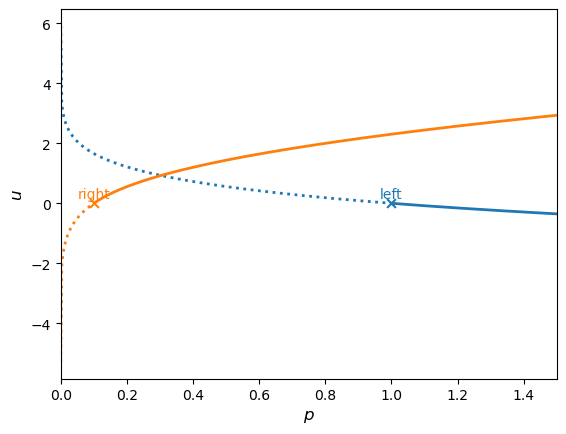

In [6]:
left = State(p=1.0, u=0.0, rho=1.0)
right = State(p=0.1, u=0.0, rho=0.125)

rp = RiemannProblem(left, right)
rp.find_star_state()

fig = plot_hugoniot(rp)
print(rp)

In this figure, a shock is shown as a solid line and a rarefaction is shown as a dotted line.  The solution is where the curves intersect, and we see that the a shock connects the right state to the star state and a rarefaction connects the left state to the star state.

Now let's consider the case of expansion:

pstar = 0.05568299200702868, ustar = 0.0


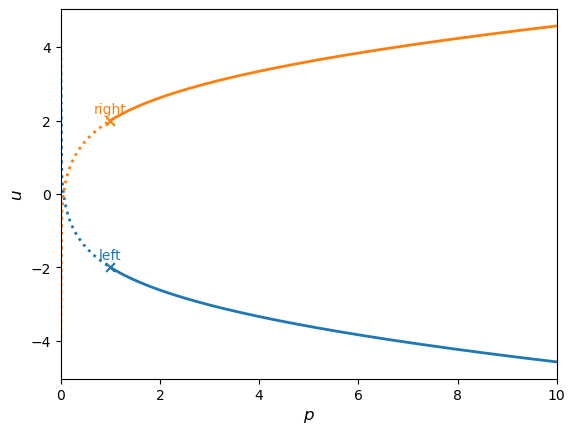

In [7]:
left = State(p=1.0, u=-2.0, rho=1.0)
right = State(p=1.0, u=2.0, rho=1.0)

rp = RiemannProblem(left, right)
rp.find_star_state()

fig = plot_hugoniot(rp, p_max=10)
print(rp)

Here we see that the star state is reached by 2 rarefaction waves.

## Approximate Riemann solvers

The general Riemann problem is expensive, especially for a general equation of state.  In particular, for a general EOS, integrating the Riemann invariants can be time-consuming,
and a method that is often used instead is the *two-shock approximation* (this is done, for example, in the Colella & Glaz 1985 paper linked above).

In the two-shock approximation, we simply solve for the star state using the shock jump
conditions regardless of whether there is compression.

```{admonition} Exercise

Modify our Riemann star state solver above to do the two-shock approximation and plot
the phase diagram for the two example problems above to see how they differ
```